# 4. Evaluation Metrics for Classification

In [120]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [122]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# fix name of columns
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Get list of categorical type columns
categorical_columns = list(df.dtypes[df.dtypes.eq("object")].index)

for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")

# Parse totalcharges to numeric and replace invalids with NAN
df["totalcharges"] = pd.to_numeric(df.totalcharges, errors="coerce").fillna(0)

# Parse yes to 1 no to 0
df["churn"] = df.churn.eq("yes").astype(int)

In [123]:
df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=1,
)
df_train, df_val = train_test_split(
    df_full_train,
    test_size=(0.2 / 0.8),
    random_state=1,
)

# Reset index and get y vectors
target = "churn"

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

In [124]:
numerical = list(df_full_train.dtypes[df_full_train.dtypes.ne("object")].index)[1:-1]
print(numerical)
categorical = [col for col in list(df_full_train.dtypes.index) if col not in numerical][1:-1]
print(categorical)

['tenure', 'monthlycharges', 'totalcharges']
['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']


In [125]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient="records")

# fit and transform
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [126]:
val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.fit_transform(val_dicts)

# 1st column is prob for 0, 2nd for 1
y_pred = model.predict_proba(X_val)[:,1]

# People will churn if prob >= 0.5
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547


## 4.2 Accuracy and dummy model

[video](https://www.youtube.com/watch?v=FW_l7lB0HUI&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR)

[Slides](https://www.slideshare.net/AlexeyGrigorev/ml-zoomcamp-4-evaluation-metrics-for-classification)


## Notes

**Accuracy** measures the fraction of correct predictions. Specifically, it is the number of correct predictions divided by the total number of predictions. 

We can change the **decision threshold**, it should not be always 0.5. But, in this particular problem, the best decision cutoff, associated with the hightest accuracy (80%), was indeed 0.5. 

Note that if we build a **dummy model** in which the decision cutoff is 1, so the algorithm predicts that no clients will churn, the accuracy would be 73%. Thus, we can see that the improvement of the original model with respect to the dummy model is not as high as we would expect. 

Therefore, in this problem accuracy can not tell us how good is the model because the dataset is **unbalanced**, which means that there are more instances from one category than the other. This is also known as **class imbalance**. 

**Classes and methods:**

* `np.linspace(x,y,z)` - returns a numpy array starting at `x` until `y` with `z` evenly spaced samples 
* `Counter(x)` - collection class that counts the number of instances that satisfy the `x` condition
* `accuracy_score(x, y)` - sklearn.metrics class for calculating the accuracy of a model, given a predicted `x` dataset and a target `y` dataset. 

In [127]:
(y_val == churn_decision).sum() / len(y_val)

0.8034066713981547

In [128]:
from sklearn.metrics import accuracy_score

In [129]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [130]:
# Testing more thresholds
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    # churn_decision = (y_pred >= t)
    # score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val, y_pred >= 0.5)
    print("%.2f => %.3f" % (t, score))
    scores.append(score)

0.00 => 0.803
0.05 => 0.803
0.10 => 0.803
0.15 => 0.803
0.20 => 0.803
0.25 => 0.803
0.30 => 0.803
0.35 => 0.803
0.40 => 0.803
0.45 => 0.803
0.50 => 0.803
0.55 => 0.803
0.60 => 0.803
0.65 => 0.803
0.70 => 0.803
0.75 => 0.803
0.80 => 0.803
0.85 => 0.803
0.90 => 0.803
0.95 => 0.803
1.00 => 0.803


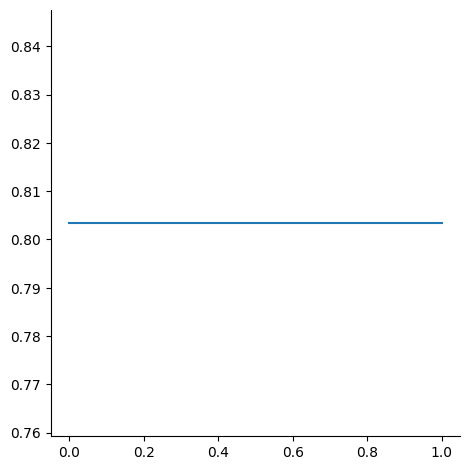

In [131]:
sns.relplot(x=thresholds, y=scores, kind="line");

In [132]:
from collections import Counter
Counter(y_pred >= 1.0)

Counter({False: 1409})

## 4.3 Confusion table

[video](https://www.youtube.com/watch?v=Jt2dDLSlBng&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR)

[Slides](https://www.slideshare.net/AlexeyGrigorev/ml-zoomcamp-4-evaluation-metrics-for-classification)


## Notes

Confusion table is a way of measuring different types of errors and correct decisions that binary classifiers can make. Considering this information, it is possible to evaluate the quality of the model by different strategies.

When comes to a prediction of an LR model, each falls into one of four different categories:

* Prediction is that the customer WILL churn. This is known as the **Positive class**
    * And Customer actually churned - Known as a **True Positive (TP)**
    * But Customer actually did not churn - Knwon as a **False Positive (FP)**
* Prediction is that the customer WILL NOT churn' - This is known as the **Negative class**
    * Customer did not churn - **True Negative (TN)**
    * Customer churned - **False Negative (FN)**

'Confusion Table' is a way to summarize the above results in a tabular format, as shown below: 

|**Actual :arrow_down:     Predictions:arrow_right:**|**Negative**|**Positive**|
|:-:|---|---|
|**Negative**|TN|FP|
|**Postive**|FN|TP| 

The **accuracy** corresponds to the sum of TN and TP divided by the total of observations. 


In [133]:
actual_positive = y_val == 1
actual_negative = y_val == 0

In [134]:
predict_positive = y_pred >= 0.5
predict_negative = y_pred < 0.5

In [135]:
print(actual_positive.sum())
print(actual_negative.sum())
print(predict_positive.sum())
print(predict_negative.sum())

386
1023
311
1098


In [136]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
tp, tn


(210, 922)

In [137]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
fp, fn

(101, 176)

In [138]:
confusion_matrix = np.array([
    [tn, fp], 
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [139]:
# Normalizing as percent
(confusion_matrix / confusion_matrix.sum()).round(3) * 100

array([[65.4,  7.2],
       [12.5, 14.9]])

## 4.4 Precision and Recall

[video](https://www.youtube.com/watch?v=gRLP_mlglMM&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR)

[Slides](https://www.slideshare.net/AlexeyGrigorev/ml-zoomcamp-4-evaluation-metrics-for-classification)


## Notes

**Precision** tell us the fraction of positive predictions that are correct. It takes into account only the **positive class** (TP and FP - second column of the confusion matrix), as is stated in the following formula:


$$P = \cfrac{TP}{TP + FP}$$


**Recall** measures the fraction of correctly identified postive instances. It considers parts of the **postive and negative classes** (TP and FN - second row of confusion table). The formula of this metric is presented below: 


$$R = \cfrac{TP}{TP + FN}$$


 In this problem, the precision and recall values were 67% and 54% respectively. So, these measures reflect some errors of our model that accuracy did not notice due to the **class imbalance**. 

In [140]:
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

**Precision:** how many positive predictions are correct

In [141]:
P = tp / (tp + fp)
P

0.6752411575562701

**Recall** fraction of correctly identified positive examples

In [142]:
R = tp / (tp + fn)
R

0.5440414507772021

## 4.5 ROC Curves

[video](https://www.youtube.com/watch?v=dnBZLk53sQI&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR)

[video](https://www.youtube.com/watch?v=B5PATo1J6yw&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR)


[Slides](https://www.slideshare.net/AlexeyGrigorev/ml-zoomcamp-4-evaluation-metrics-for-classification)


## Notes

ROC stands for Receiver Operating Characteristic, and this idea was applied during the Second World War for evaluating the strength of radio detectors. This measure considers **False Positive Rate** (FPR) and **True Postive Rate** (TPR), which are derived from the values of the confusion matrix.

**FPR** is the fraction of false positives (FP) divided by the total number of negatives (FP and TN - the first row of confusion matrix), and we want to `minimize` it. The formula of FPR is the following: 

<p align="center">
    <img src="https://render.githubusercontent.com/render/math?math=\large \frac{FP}{TN %2B FP}"/>
</p>

In the other hand, **TPR** or **Recall** is the fraction of true positives (TP) divided by the total number of positives (FN and TP - second row of confusion table), and we want to `maximize` this metric. The formula of this measure is presented below: 

<p align="center">
    <img src="https://render.githubusercontent.com/render/math?math=\large \frac{TP}{TP %2B FN}"/>
</p>

ROC curves consider Recall and FPR under all the possible thresholds. If the threshold is 0 or 1, the TPR and Recall scores are the opposite of the threshold (1 and 0 respectively), but they have different meanings, as we explained before. 

We need to compare the ROC curves against a point of reference to evaluate its performance, so the corresponding curves of random and ideal models are required. It is possible to plot the ROC curves with FPR and Recall scores vs thresholds, or FPR vs Recall. 


**Classes and methods:** 
* `np.repeat([x,y], [z,w])` - returns a numpy array with a z number of x values, and a w number of y values. 
* `roc_curve(x, y)` - sklearn.metrics class for calculating the false positive rates, true positive rates, and thresholds, given a target x dataset and a predicted y dataset. 


In [143]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [144]:
R

0.5440414507772021

In [145]:
fpr = fp / (tn + fp)
fpr

0.09872922776148582

In [146]:
# We compute for every threshold
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:

    actual_positive = y_val == 1
    actual_negative = y_val == 0
    predict_positive = y_pred >= t
    predict_negative = y_pred < t

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    # tpr = tp / (tp + fn)
    # fpr = fp / (tn + fp)

    scores.append((t, tp, fp, fn, tn))

len(scores)


101

In [147]:
cols = "t, tp, fp, fn, tn".split(", ")

In [148]:
df_scores = pd.DataFrame(scores, columns=cols)
df_scores[::10]

,t,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [149]:
df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores["fpr"] = df_scores.fp / (df_scores.tn + df_scores.fp)
df_scores[::10]

,t,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


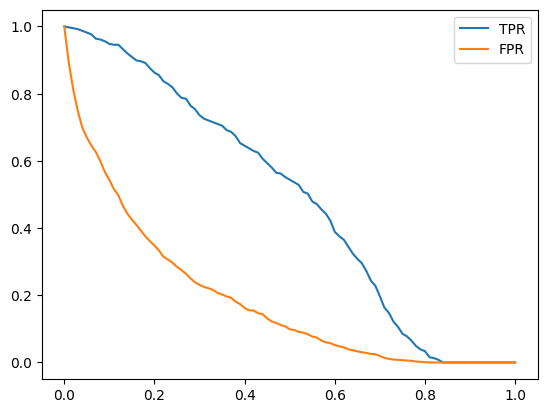

In [150]:
plt.plot(df_scores.t, df_scores.tpr, label="TPR")
plt.plot(df_scores.t, df_scores.fpr, label="FPR")
plt.legend()

### Random model

In [151]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [152]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [153]:
def tpr_fpr_dataframe(y_val, y_pred):
    # We compute for every threshold
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:

        actual_positive = y_val == 1
        actual_negative = y_val == 0
        predict_positive = y_pred >= t
        predict_negative = y_pred < t

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    cols = "t, tp, fp, fn, tn".split(", ")
    df_scores = pd.DataFrame(scores, columns=cols)
    
    df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores["fpr"] = df_scores.fp / (df_scores.tn + df_scores.fp)

    return df_scores

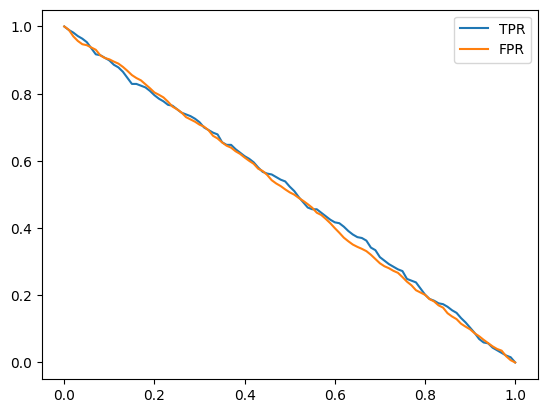

In [154]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
plt.plot(df_rand.t, df_rand.tpr, label="TPR")
plt.plot(df_rand.t, df_rand.fpr, label="FPR")
plt.legend()

### Ideal model

In [155]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [156]:
y_ideal = np.repeat([0, 1],[num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [157]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [158]:
1 - y_val.mean()

0.7260468417317246

In [159]:
((y_ideal_pred >= .726) == y_ideal).mean()

1.0

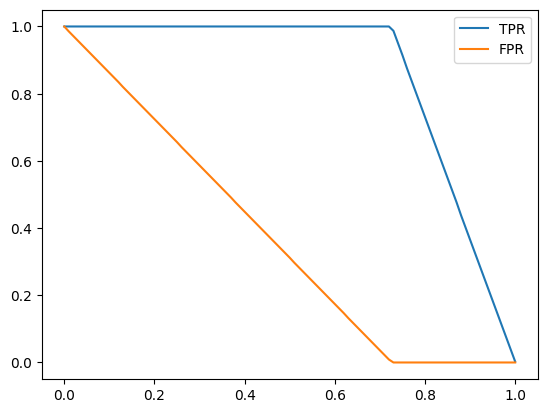

In [160]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
plt.plot(df_ideal.t, df_ideal.tpr, label="TPR")
plt.plot(df_ideal.t, df_ideal.fpr, label="FPR")
plt.legend()

### Putting everything together

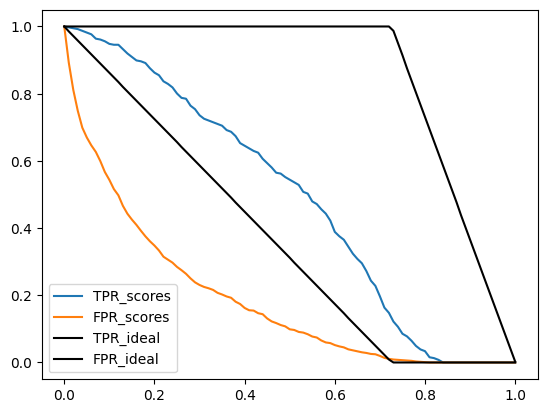

In [161]:
plt.plot(df_scores.t, df_scores.tpr, label="TPR_scores")
plt.plot(df_scores.t, df_scores.fpr, label="FPR_scores")
plt.legend()
df_rand = tpr_fpr_dataframe(y_val, y_rand)
# plt.plot(df_rand.t, df_rand.tpr, label="TPR_rand")
# plt.plot(df_rand.t, df_rand.fpr, label="FPR_rand")
# plt.legend()
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
plt.plot(df_ideal.t, df_ideal.tpr, label="TPR_ideal", color="black")
plt.plot(df_ideal.t, df_ideal.fpr, label="FPR_ideal", color="black")
plt.legend()

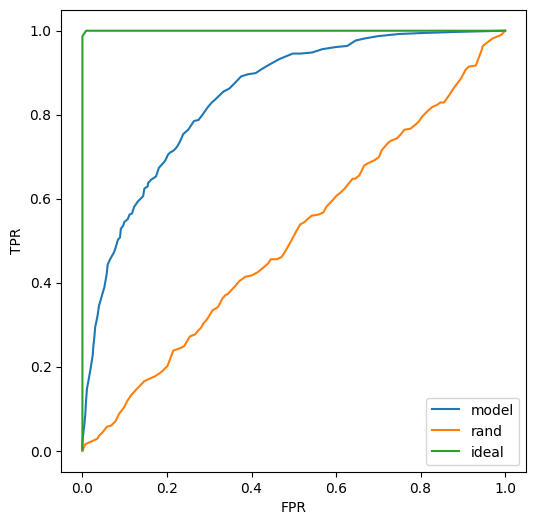

In [162]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr, df_scores.tpr, label="model")
plt.plot(df_rand.fpr, df_rand.tpr, label="rand")
plt.plot(df_ideal.fpr, df_ideal.tpr, label="ideal")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

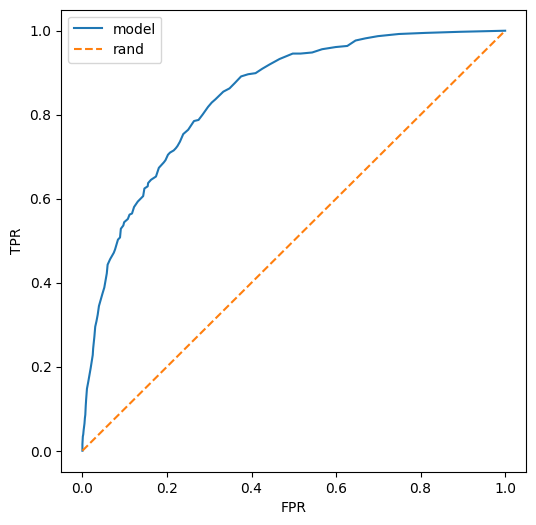

In [163]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr, df_scores.tpr, label="model")
plt.plot([0,1],[0,1], label="rand", linestyle="--")
# plt.plot(df_ideal.fpr, df_ideal.tpr, label="ideal")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

In [164]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

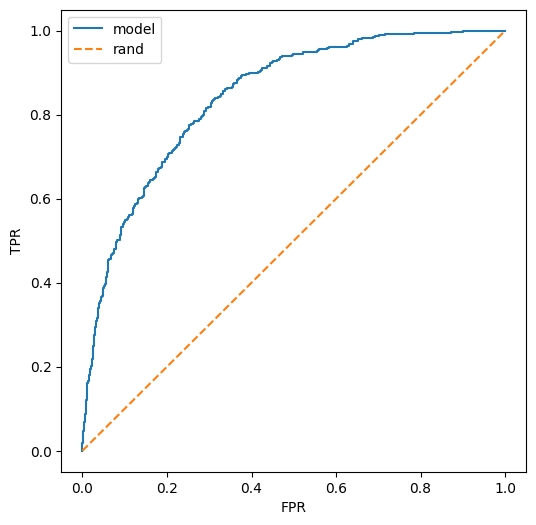

In [165]:
plt.figure(figsize=(6,6))

plt.plot(fpr, tpr, label="model")
plt.plot([0,1],[0,1], label="rand", linestyle="--")
# plt.plot(df_ideal.fpr, df_ideal.tpr, label="ideal")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

## 4.6 ROC AUC

[video](https://www.youtube.com/watch?v=hvIQPAwkVZo&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR)

[Slides](https://www.slideshare.net/AlexeyGrigorev/ml-zoomcamp-4-evaluation-metrics-for-classification)


## Notes

The Area under the ROC curves can tell us how good is our model with a single value. The AUROC of a random model is 0.5, while for an ideal one is 1. 

In ther words, AUC can be interpreted as the probability that a randomly selected positive example has a greater score than a randomly selected negative example.

**Classes and methods:** 

* `auc(x, y)` - sklearn.metrics class for calculating area under the curve of the x and y datasets. For ROC curves x would be false positive rate, and y true positive rate. 
* `roc_auc_score(x, y)` - sklearn.metrics class for calculating area under the ROC curves of the x false positive rate and y true positive rate datasets.

In [166]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.8438530381535563

In [167]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [168]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [169]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438530381535563

In [170]:
roc_auc_score(y_ideal, y_ideal_pred)

1.0

In [171]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [172]:
import random

In [173]:
n = 100000
succes = 0

for i in range(n):
    pos_idx = random.randint(0, len(pos) - 1)
    neg_idx = random.randint(0, len(neg) - 1)

    if pos[pos_idx] > neg[neg_idx]:
        succes += 1

succes / n

0.84414

In [117]:
n = 100000
pos_idxs = np.random.randint(0, len(pos), size=n)
neg_idxs = np.random.randint(0, len(neg), size=n)

In [119]:
(pos[pos_idxs] > neg[neg_idxs]).mean()

0.84297